(section4.3)=
# 4.3 Building a simple model


In this section we will use what we've learned in [_Section 4.1_](section4.1) and [_Section 4.2_](section4.2) to begin modelling the EQLS dataset.

## Recap
In [_Section 3.5_](section3.5) we selected some interesting variables and looked at some of the relationships - in particular, in our _material_ variables `DeprIndex` and `AccomProblems`. We also visualised the distribution of the Deprivation Index (`DeprIndex`) for different categories of the self-reported Health (`SRH`) and found that there was an obvious relationship between these variables. Furthermore, following previous research done on the topic (and also for simplicity), we decided to binarise our variable of interest `SRH` in two categories of `Fair` and `Poor` health.

## Data processing 

Let's start building a simple model attempting to predict `SRH` using `DeprIndex` using data from the UK. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_style("white")

First  let's load the data in the same way as we did in [_Section 3.5_](section3.5). We can access the data by downloading the [csv](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=7724#!/details) option from here.

Unzip the data to `$PROJECT_ROOT/data` (where `$PROJECT_ROOT` is the root of the cloned github repository for this course).
This should give you `$PROJECT_ROOT/data/UKDA-7724-csv` directory.



In [2]:
datafolder = '../../../data/UKDA-7724-csv/' # should match the path you unzipped the data to
df = pd.read_csv(datafolder + 'csv/eqls_2011.csv')
df_map = pd.read_csv(datafolder + 'mrdoc/excel/eqls_api_map.csv', encoding='latin1')

In [3]:
# we are only interested in the UK for this example.
df = df.query('Y11_Country == 27')

To make the manipulation easier we select a subset of the data with only the variables we want and rename them into something more readable.

In [4]:
var_map = {"Y11_Q42": "SRH",
           'Y11_Deprindex': 'DeprIndex',
           "Y11_Accommproblems": 'AccomProblems',
           "Y11_Incomequartiles_percapita" : "IncomeQuartiles",
           "Y11_HHsize": "HouseholdSize",
           "Y11_Q32": "Children",
           "DV_Q7":"WorkingHours",
           "Y11_ISCEDsimple":"ISCED",
           "Y11_SocExIndex":"SocialExclusionIndex",
           "Y11_MWIndex": "MentalWellbeingIndex",
           "Y11_Agecategory":"AgeCategory",
           "Y11_HH2a":"Gender",
           "Y11_Q31":"MaritalStatus",
           "Y11_Country":"Country"
}

df.rename(columns=var_map, inplace=True)
df_set = df[var_map.values()]

In _Section 3.5_ we realised that variables like `WorkingHours`, `IncomeQuartiles` have a lot of missing data, so we decided to not use them in the modeling. Furthermore, we dropped the remaining rows with missing data (**warning**: this shouldn't be done lightly without having explored the missingness of the data, here we are doing for simplicity and to focus on the modelling).

In [5]:
df_model = df_set.drop(columns=['WorkingHours','IncomeQuartiles']).dropna() #we defer imputation to a later date. For now we remove na.

Finally, we must dichotomise our `SRH` variable.

In [6]:
# dichotomise SRH
df_model['SRH_binary'] = df_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)

## Logistic regression 

We want to predict the probability of SRH being 1 (i.e good health). In [_Section 4.2_](section4.2) we saw that we do this by predicting the log-odds of $p(x)$. Why?

The odds of something are the probability of it happening divided by the probability of it not happening:

$$ odds(x) = \frac{p(x)}{1 - p(x)} $$

Let's have a simple example. Say you have a bag of 5 balls, with 4 red and 1 blue. The probability of drawing a red ball is $\frac{4}{5}$, and the probability of drawing a blue ball is $\frac{1}{5}$. The probability of drawing a blue ball is the same as the probability of _not drawing a red ball_, which is $1-P(red) = 1-\frac{4}{5} = \frac{1}{5}$.

Now, the odds of drawing a red ball is related but not identical to the probability of drawing of a red ball. Instead, it is a measure of how likely drawing a red ball is _in comparison to_ not drawing a red ball. In our simple example we can see the difference. There are four times as many red balls as blue, so you are four times as likely to draw one. The probability, in contrast, is 80%. 

So:

$$ odds(red) = \frac{P(red)}{1-P(red)} = \frac{\frac{4}{5}}{1-\frac{4}{5}} = \frac{\frac{4}{5}}{\frac{1}{5}} = 4 $$


**Why do we use log(odds)?**

The left side of the figure below shows the odds of a binary outcome with different probabilities for p(x). You can see that as $p(x)$ becomes closer to 1, $1-p(x)$ becomes infinitesimal, so the odds tend towards infinitely large. 


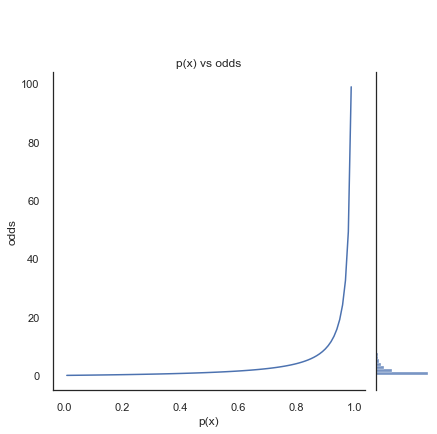

In [7]:
p = np.linspace(.01,.99,100)
odds = p / (1-p)

g = sns.JointGrid()
ax = sns.lineplot(x=p, y=odds, ax=g.ax_joint)
sns.histplot(y=odds, ax=g.ax_marg_y)
g.ax_marg_x.set_axis_off()
ax.set(xlabel='p(x)', ylabel='odds', title= 'p(x) vs odds')
plt.show()

In regression we want equal probability to be placed to either side of the odds function. Taking the log-odds transforms the exponential odds into a symmetrical and continuous function.
As shown below.

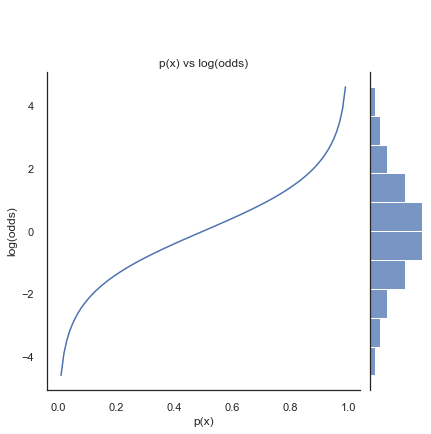

In [8]:
g = sns.JointGrid()
ax =sns.lineplot(x=p, y=np.log(odds), ax=g.ax_joint)
sns.histplot(y=np.log(odds), ax=g.ax_marg_y)
g.ax_marg_x.set_axis_off()
ax.set(xlabel='p(x)', ylabel='log(odds)', title= 'p(x) vs log(odds)')
plt.show()

Using log-odds gives us the logistic regression formula from [_Section 4.2_](section4.2): 


$$
\log\left(\frac{p({\bf x})}{1 - p({\bf x})}\right) = \beta_0 + \beta_1 x_1 + \ldots  + \beta_{n} x_{n}
$$

**Classifying log-odds**

The log-odds of $x$ are also referred to by the function $logit(x)$. We have shown that from $p(x)$ we can get $logit(x)$. To convert $logit(x)$ into a categorical variable $y={0,1}$ we need a probability, let's call it $\hat{p}$, so that we can state that if $\hat{p}\geq0.5$ then $y=1$.

The **sigmoid** function is the inverse of the logit function. If we say that the output of $logit(x)$ is $\hat{x}$, then:

$$ \frac{1}{1 + e^{-\hat{x}}} $$

````{margin}
```{admonition} Sigmoid intuition
:class: dropdown, tip
The intuition for the sigmoind function is as follows. 

- A fraction with $1$ as the numerator always has a maximum of $1/1 = 1$. As the denominator grows, the value gets closer to $0$, but never below it. 
- $x^{-y}  = \frac{1}{x^y}$, so $e^{-\hat{x}} = \frac{1}{e^{\hat{x}}}$
- $e^{log(odds)} = odds$ So $e^{-log(odds)} = \frac{1}{odds}$. The inverse of the odds how more likely an event is to _not_ happen. 
- So, the sigmoid function is actually $\frac{1}{1+\frac{1}{odds}}$. In other words, when the odds are high the sigmoid function is close to 1, as they decrease the sigmoid function goes towards zero, bounded by zero and 1. 
- This latter function cancels out to $p(x)$. 
```
````

Now, let's return to modelling our data.     

## Simple model 1: modelling the Self-reported Health as a function of the Deprivation Index

The model is:
    $$ logit(p(x)) = intercept + \beta_1*deprindex $$

We now remind ourselves of our data and the behaviour of `DeprIndex` for our two `SRH` categories

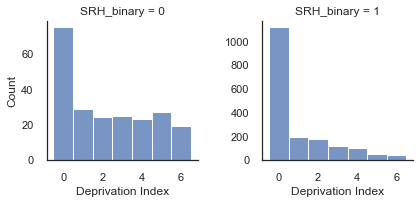

In [9]:
g = sns.FacetGrid(df_model, col="SRH_binary", sharey=False)
g.map_dataframe(sns.histplot, 'DeprIndex',discrete=True)
g.set_axis_labels("Deprivation Index", "Count")
plt.show()


Notice that the mode is zero in both cases, but there is a much higher proportion of `DeprIndex` scores in [3-6] when SRH = 0 compared to when SRH = 1. From this we already know that as `DeprIndex` decreases we may expect that the odds of SRH_binary=1 will _increase_.

Let's now fit our model to the data using `statsmodels` library.


In [10]:
import statsmodels.api as sm

data = df_model.loc[:,'DeprIndex']

# Intercept is not added by default in Statsmodels, we need to add a constant (and array of 1s) for intercept
X_atr = sm.add_constant(data) 
#Create model instance
logit_model = sm.Logit(df_model.SRH_binary.values, X_atr)
result = logit_model.fit() #Fit model

# extract coefficient and intercept.
intercept = np.array(result.params[0])
coef1 = np.array(result.params[1])


Optimization terminated successfully.
         Current function value: 0.325395
         Iterations 6


Now we have fitted our model let us explore it so we understand what the model thinks is going on in the data.

Interpreting the model is the first step in model evaluation. In _Section 4.3_ we will assess model performance in more detail.

```{admonition} Ignorant Models
:class: important
First, remember that models are ignorant. They only know about the information we have given them. In our case this means that the model does not know that `DeprIndex` is an ordinal value, rather it thinks it is continuous. This means that _according to the model's universe_ values less than zero are allowed in `DeprIndex`, as well as values greater than 6. Whether this is an issue or not depends on context and the conclusions one is drawing.
```
After the fit we have our intercept and coef, so we can predict the log-odds and p(x) using what we've learned above.

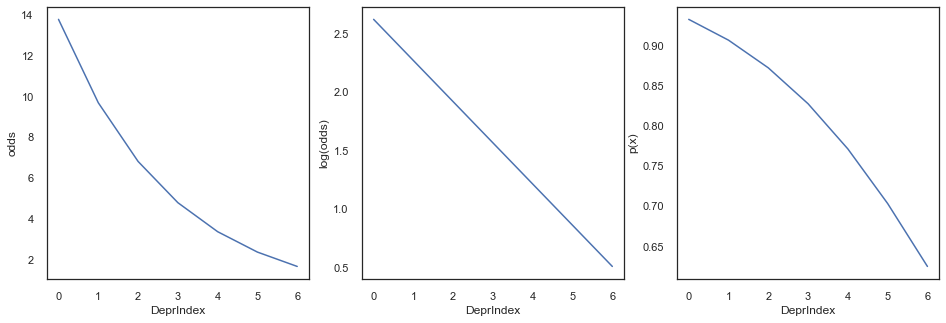

In [11]:
x = list(set(df_model.DeprIndex.values))
sigm = lambda x: 1/ (1+np.exp(-x))

fig, axes = plt.subplots(1,3, figsize=(16,5))


logodds = intercept + coef1*x
odds = np.exp(logodds)
probs = sigm(logodds)

axes[0].plot(x,odds)
axes[0].set_ylabel('odds')
axes[1].plot(x,logodds)
axes[1].set_ylabel('log(odds)')
axes[2].plot(x,probs)
axes[2].set_ylabel('p(x)')
for ax in axes: ax.set_xlabel('DeprIndex')
plt.show()


We can see from the odds that even with `DeprIndex` is 6 (highest deprivation) the variable SRH is around 2 times more likely to be 1 (good health) rather than 0. So, our model currently predicts `SRH_binary == 1` for _every single_ output of `DeprIndex` in our dataset.

This seems like strange behaviour. We know there are zeroes in our dataset, so does predicting 100% good health mean that our model is bad? 


Let's compare this with the outputs calculated from our data:

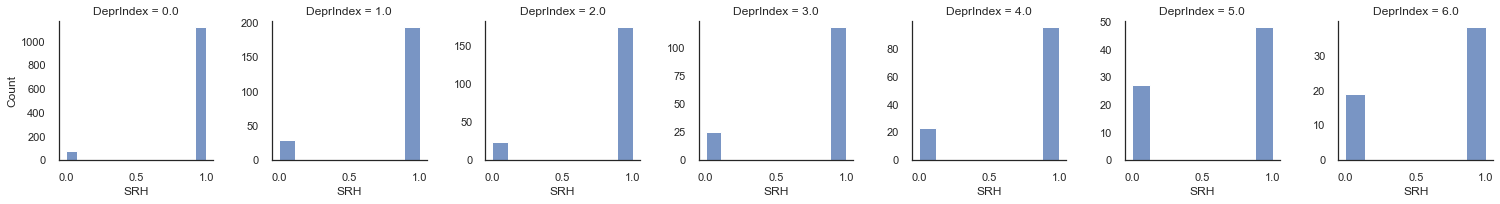

In [12]:
g = sns.FacetGrid(df_model, col="DeprIndex", sharey=False)
g.map_dataframe(sns.histplot, 'SRH_binary')
g.set_axis_labels("SRH", "Count")
plt.show()

                        

From these figures we can basically estimate $p(x)$ directly from the data for each category. If you have a set of {0,1}, the the proportion of ones is simply the mean. From this proportion we calculate the odds and log odds.

In the next set of plots we will superpose this real data on top of the model regression lines and examine how well the model is representing our data.

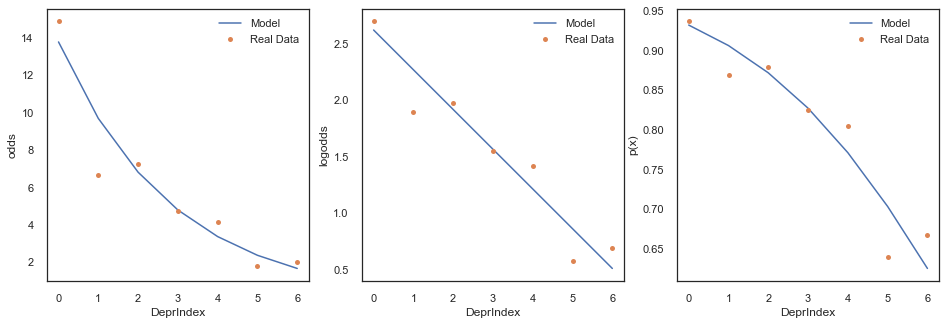

In [13]:
df_lo=pd.pivot_table(df_model, index=['DeprIndex'], values='SRH_binary', aggfunc=lambda x: np.mean(x))

px=df_lo.SRH_binary.values

x = list(set(data))
x.sort()


fig, axes = plt.subplots(1,3, figsize=(16,5))

odds = np.exp(logodds)
probs = sigm(logodds)

axes[0].plot(x,odds, label='Model')
axes[0].plot(x, px / (1-px), '.', label='Real Data', ms=10)
axes[0].set_ylabel('odds')
axes[1].plot(x,logodds, label='Model')
axes[1].plot(x, np.log(px / (1-px)), '.', label='Real Data', ms=10)
axes[1].set_ylabel('logodds')
axes[2].plot(x,probs, label='Model')
axes[2].plot(x,px, '.', label='Real Data',ms=10)
axes[2].set_ylabel('p(x)')

for ax in axes: 
    ax.set_xlabel('DeprIndex')
    ax.legend()
plt.show()


We can see above that logistic model has learned the data pretty well, even though when we binarise the output it is clearly not predicting any poor health.

This is because the predicted binarisation is sort of a hack to get a single predicted classification. What the logistic regression really learns about pretty well is the ratio of responses. If we look at the proportions of good health to poor health in the panel plot below we can see that _even at the highest deprivation index_ we have approximately double the amount of 'good health' to 'poor health'. This is what the model has learned. 

Let's now examine the summary of our fit:

In [14]:
print(result.summary())


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2004
Model:                          Logit   Df Residuals:                     2002
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                 0.06533
Time:                        15:30:48   Log-Likelihood:                -652.09
converged:                       True   LL-Null:                       -697.67
Covariance Type:            nonrobust   LLR p-value:                 1.324e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6232      0.102     25.808      0.000       2.424       2.822
DeprIndex     -0.3520      0.036     -9.815      0.000      -0.422      -0.282





```{admonition} Interpreting the Fit Output

The fitted coeffient `DeprIndex` reflects the change of log odds of each increment on our independent variable (since the model thinks our predictor is a continous variable). This corresponds to the slope in the middle figure above (`DeprIndex` vs `log(odds`). We can also get the value from the fitted intercept from the same figure - this is the log(odds) value for when our `SRH` dependent variable is zero.

These coefficients come with a Standard Error (`std err`), which is an estimate of the standard deviation of the coefficient, representing the amount of sampling variation is expected in the coefficient. A low std error compared the value of the coefficient signifies a high significance for your coefficient (i.e. taking into account the variability in the coefficient the magnitude is likely to be non-zero). The significance is also reflected by the `z` and `p-value` (P>|z|) and means how likely the coefficient is measured through our model by chance. Finally, the [0.025 and 0.975] measurements of values of the coefficients within within two standard deviations.
    
A `p-value` is a useful indication of whether or not your measurement might be a product of chance. However, it does not tell you whether the differences between the null model and your model are large enough to have practical real-life implications. Or indeed, whether your null model was ever a realistic comparison in the first place. Tests of statistical difference are not a replacement for understanding your model's universe, but they can be useful additional evidence if understood well.
    
```

Note that p(x) vs  `DeprIndex` on the right of our figures above looks nothing like our nice sigmoid curve. What's happening here? 
 
Remember that the model thinks `DeprIndex` is a continuous variable. If we predict $P(x)$ along a much wider scale than our dataset we get a better idea of the probability curve. 

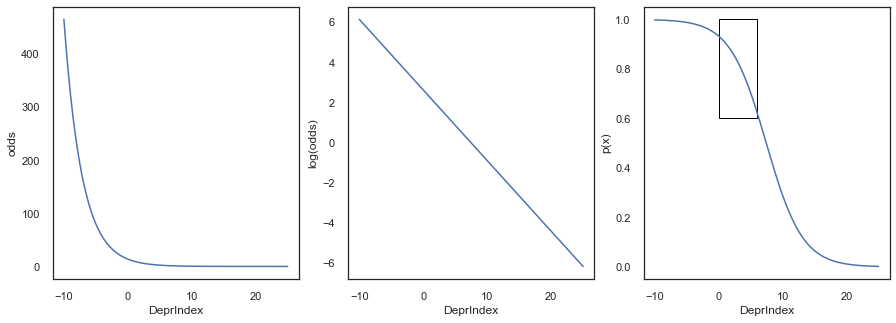

The Decision Boundary is at: 7.451527883036597


In [15]:
x = np.linspace(-10,25,200)
# create a function that starts at p(x) instead of x.

fig, axes = plt.subplots(1,3, figsize=(15,5))

logodds = intercept + coef1*x
odds = np.exp(logodds)
probs = sigm(logodds)

axes[0].plot(x,odds)
axes[0].set_ylabel('odds')
axes[1].plot(x,logodds)
axes[1].set_ylabel('log(odds)')
axes[2].plot(x,probs)
axes[2].set_ylabel('p(x)')
axes[2].add_patch(plt.Rectangle((0,.6),6,.4, fill=False, edgecolor="black"))
for ax in axes: ax.set_xlabel('DeprIndex')
plt.show()



print(f"The Decision Boundary is at: {-intercept /coef1}")

When two binary outcomes are equally likely, $odds=1, log(odds)=0, \text{and } p(x)=0.5$. We can use this knowledge to calculate the decision boundary, meaning the point along the `DeprIndex` scale where the regression model changes its prediction of which outcome is more likely:

$$
\begin{aligned}
0 &= intercept + \beta_1*deprindex \\
\\
\frac{-intercept}{\beta_1} &= deprindex \\ 
\end{aligned}
$$

In the current model this is around 7.5.

# Simple model 2: modelling SRH as a function of deprivation and age


Let's now add a new predictor to our model, the age of the respondents. We expect for age to be one of the most relevant variables influencing how people experience health and be orthogonal to what our first variable of interest `DeprIndex` is actually measuring.

Let's take a look a how our `SRH` variable behaves for different categories of age and deprivation.

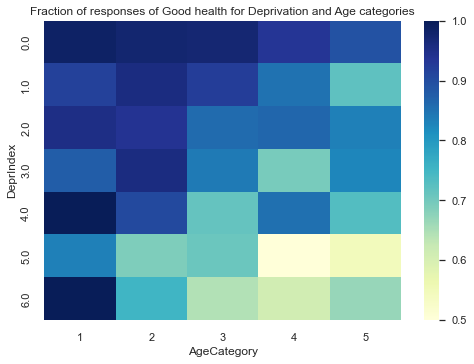

In [16]:
ax = plt.axes()
df=pd.pivot_table(df_model, index=['DeprIndex'], values='SRH_binary', columns=['AgeCategory'], aggfunc=lambda x: np.mean(x))
sns.heatmap(df, cmap="YlGnBu")
ax.set_title('Fraction of responses of Good health for Deprivation and Age categories')

plt.show()

In the figure above we observe some interesting variability across both variables. For example, older respondents in that are the least deprived are much less likely to report poor health than respondents of the same age group in highly deprived areas.

Our research question is interested on the socio-economical factors that can affect `SRH`. `Age` is not a socio economical factor, however, seeing the variability that it can have with both deprivation and self-reported health, it would be unwise to not take into account the age in our model.

In here, `Age` is basically is a confounding variable, which is a factor other than the one being studied that is associated both with the dependent variable (`SRH`) and with the factor being studied (`DeprIndex`). A confounding variable may distort or mask the effects of the `DeprIndex` on `SRH`.

Including `Age` in our model is essentially "controlling" for it. Remember that coefficients indicate the influece of a predictor on the dependent variable _assuming the other inputs are known_. Which in principle means that we compare different deprivation groups on fixed slices of age groups.

To make sure that are assumptions are right and that `Age` is an appropriate control variable, we look at the correlations between `Age`, `DeprIndex` and our binarised `SRH`.

In [17]:
df_model[['DeprIndex','SRH_binary','AgeCategory']].corr(method='spearman')

,DeprIndex,SRH_binary,AgeCategory
DeprIndex,1.000000,-0.214105,-0.177473
SRH_binary,-0.214105,1.000000,-0.107239
AgeCategory,-0.177473,-0.107239,1.000000


As we already know, `DeprIndex` has inverse relationship with the self-reported health. This relationship is slightly stronger than the relationship with of `SRH` and `Age`. 

When we control for variables that have a positive correlation with both the independent and the dependent variable, the original relationship will be pushed down, and become more negative. The same is true if we control for a variable that has a negative correlation with both independent and dependent. It is thus likely that the relationship between `DeprIndex` and `SRH` will become stronger under control for `Age`.

Let's fit the model and see,

In [18]:
data = df_model[['AgeCategory','DeprIndex']]
X_Age_Dep = sm.add_constant(data) #add constant for intercept
logit_model2 = sm.Logit(df_model.SRH_binary.values, X_Age_Dep) #Create model instance
result2 = logit_model2.fit() #Fit model

px = result2.predict(X_Age_Dep)

print (result2.summary())

Optimization terminated successfully.
         Current function value: 0.314769
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2004
Model:                          Logit   Df Residuals:                     2001
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                 0.09585
Time:                        15:30:48   Log-Likelihood:                -630.80
converged:                       True   LL-Null:                       -697.67
Covariance Type:            nonrobust   LLR p-value:                 9.048e-30
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.2763      0.301     14.230      0.000       3.687       4.865
AgeCategory    -0.4296    

Indeed, the coefficient for `DeprIndex` is more negative now that we have isolated its effects from those of `Age` on `SRH`.

Now, let's replicate the steps we showed before to see how well the model is representing our data. The next figure shows the expected probability of reporting good health for the different deprivation and age categories.

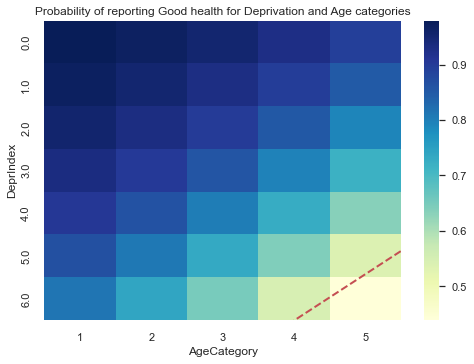

In [19]:

ax = plt.axes()
dfm2 = df_model[['AgeCategory','DeprIndex']].copy()
dfm2['px'] = px
dfm2= pd.pivot_table(dfm2, index=['DeprIndex'], values='px', columns=['AgeCategory'], aggfunc = lambda x: np.mean(x))
sns.heatmap(dfm2, cmap="YlGnBu")
ax.set_title('Probability of reporting Good health for Deprivation and Age categories')

# Decision boundary
# Tips here: https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/
ages = np.array([1, 5])
intc, b_age, b_depr = result2.params
c = -intc/b_depr
m = -b_age/b_depr
depr_boundary = m*ages + c
plt.gca().plot(ages, depr_boundary, 'r--', lw=2)

plt.show()

The figure above shows a roughly similar pattern to the one from the data a couple of cells above, showing that the model is learning the pattern from the ratio of responses as both  `DeprIndex` and `Age` increases. The decision boundary is plotted as a red dashed line.

Again, we should remember that the model thinks `DeprIndex` and `AgeCategory` are continuous variables. If we predict  $𝑃(𝑥)$  along a much wider scale than our dataset we get a better idea of the two-dimensional probability curve.

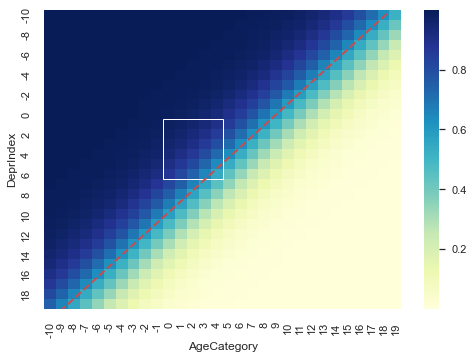

In [20]:
from matplotlib.patches import Rectangle

ages = np.arange(-10,20)
depr = np.arange(-10,20)

X=np.array(np.meshgrid(ages,depr)).reshape(2,-1).T
X_Age_Dep = sm.add_constant(X) #add constant for intercept

px=result2.predict(X_Age_Dep)

temp_df = pd.DataFrame(X, columns=['AgeCategory','DeprIndex'])
temp_df['px'] = px


dfsyn= pd.pivot_table(temp_df, index=['DeprIndex'], values='px', columns=['AgeCategory'], aggfunc = lambda x: np.mean(x))
#print(dfsyn)

# rectangle for original data
sns.heatmap(dfsyn, cmap="YlGnBu")
plt.gca().add_patch(plt.Rectangle((10,11),5,6, fill=False, edgecolor="white"))

# Decision boundary
# Tips here: https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/
intc, b_age, b_depr = result2.params
c = -intc/b_depr
m = -b_age/b_depr
depr_boundary = m*ages + c
# not sure why but heatmap coordinate system starts with 0,0, adjust so (0,0) on our scale is (10,10)
plt.gca().plot(ages+10, depr_boundary+10, 'r--', lw=2)

plt.show()


Our data space lives in the sub-space inside the white rectangle. 

The red dashed line is the decision boundary at $p(x)=0.5$.

Imagine that the change in colour represents a change in ground height, with blue being high and cream beind low. If we extract the probability from the diagonal of our matrix we recover our nice sigmoid function.  

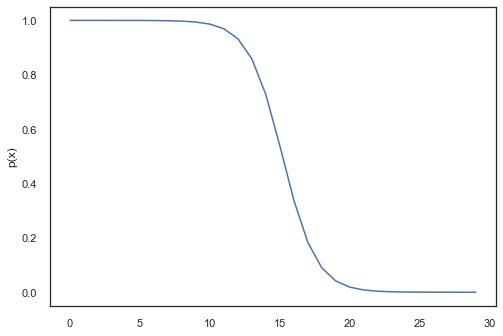

In [21]:
x = np.array(dfsyn).diagonal()
plt.plot(np.arange(0,len(x)),x)
plt.ylabel('p(x)')
plt.show()